In [1]:
import os
import pyspark
import pandas as pd
import torch
import torch.nn.functional as functional
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import warnings

from pathlib import Path

from transformers import AutoTokenizer, AutoModel, AutoConfig

from pytorch_lightning.loggers import TensorBoardLogger

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.coles import CoLESModule
from ptls.preprocessing import PandasDataPreprocessor
from ptls.data_load.datasets import MemoryMapDataset
from ptls.frames.coles import ColesDataset
from ptls.frames.coles.split_strategy import SampleSlices
from ptls.frames import PtlsDataModule
from ptls.data_load.utils import collate_feature_dict
from ptls.frames.inference_module import InferenceModule
from ptls.data_load.iterable_processing import ISeqLenLimit, FeatureFilter
from ptls.nn.trx_encoder.encoders import IdentityEncoder

from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import RocCurveDisplay
from lightgbm import LGBMClassifier

In [2]:
warnings.filterwarnings('ignore')
data_path = Path('data')
pl.seed_everything(42)
plt.style.use('bmh')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

Global seed set to 42


In [3]:
def embed_mcc_descs(mcc_descriptions, batch_size=10000):
    tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny2')
    bert = AutoModel.from_pretrained('cointegrated/rubert-tiny2').cuda()
    res = dict()
    for i in range(0, len(mcc_descriptions), batch_size):
        descs = mcc_descriptions[i:i+batch_size]
        tokens = tokenizer(descs, padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad():
            out = bert(**{k: v.to(bert.device) for k, v in tokens.items()})
    
        embeddings = functional.normalize(out.last_hidden_state[:, 0, :]).cpu()
        res.update(dict(zip(descs, embeddings)))
    return res

In [4]:
joined = pd.read_csv(data_path / 'dataset_aug_syn_03.csv').drop(columns=['mcc_description'])
joined.rename(columns={'aug_mcc_description': 'mcc_description'}, inplace=True)
embs = embed_mcc_descs(joined['mcc_description'].unique().tolist())
joined['mcc_description'] = joined['mcc_description'].apply(lambda description: embs[description])

preprocessor = PandasDataPreprocessor(
    col_id='customer_id',
    col_event_time='event_time',
    event_time_transformation='none',
    cols_category=['tr_type', 'term_id'],
    cols_numerical=['amount'],
    cols_identity=['mcc_description']
)

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
dataset = MemoryMapDataset(
    data=preprocessor.fit_transform(joined),
    i_filters=[
        ISeqLenLimit(max_seq_len=2000),
        FeatureFilter(keep_feature_names='customer_id')
    ]
)

In [6]:
TRAIN_SIZE = int(len(dataset) * 0.8)
VAL_SIZE = len(dataset) - TRAIN_SIZE

train, val = torch.utils.data.random_split(dataset, [TRAIN_SIZE, VAL_SIZE])

In [7]:
trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={'amount': 'identity'},
    embeddings={
        'tr_type': {'in': 100, 'out': 24},
    },
    custom_embeddings = {'mcc_description': IdentityEncoder(312)},
    norm_embeddings=False
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=1024,
    type='gru',
    bidir=False,
    trainable_starter='static'
)

model = CoLESModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(torch.optim.Adam, lr=0.002, weight_decay=0.0),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=10, gamma=0.9025),
)

In [8]:
train_dl = PtlsDataModule(
    train_data=ColesDataset(
        train,
        splitter=SampleSlices(
            split_count=5,
            cnt_min=15,
            cnt_max=75,
        ),
    ),
    train_num_workers=8,
    train_batch_size=128,
    valid_data=ColesDataset(
        val,
        splitter=SampleSlices(
            split_count=5,
            cnt_min=25,
            cnt_max=100
        )
    ),
    valid_batch_size=512,
    valid_num_workers=16
)

In [9]:
trainer = pl.Trainer(
    max_epochs=150,
    gpus=[1] if torch.cuda.is_available() else 0,
    enable_progress_bar=False,
    logger=TensorBoardLogger('lightning_logs', name='exogenous_text_embeddings_aug_03_pretrained')
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
%%time
trainer.fit(model, train_dl)
print(trainer.logged_metrics)

### Using embeddings for downstream task

In [11]:
train_dl = torch.utils.data.DataLoader(
    dataset=train,
    collate_fn=collate_feature_dict,
    shuffle=False,
    batch_size=512,
    num_workers=4
)

val_dl = torch.utils.data.DataLoader(
    dataset=val,
    collate_fn=collate_feature_dict,
    shuffle=False,
    batch_size=512,
    num_workers=4
)

In [12]:
inf_model = InferenceModule(
    seq_encoder
)

In [13]:
df_train = pd.concat(trainer.predict(inf_model, train_dl))
df_val = pd.concat(trainer.predict(inf_model, val_dl))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


In [14]:
target_df = pd.read_csv(data_path / 'gender_train.csv')

In [15]:
df_train = df_train.merge(target_df, how='left', on='customer_id').dropna()
df_val = df_val.merge(target_df, how='left', on='customer_id').dropna()

In [16]:
X_train = df_train.drop(columns=['gender'])
y_train = df_train['gender']
X_val = df_val.drop(columns=['gender'])
y_val = df_val['gender']
scaler = MaxAbsScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [17]:
model = LGBMClassifier(
    n_estimators=500,
    boosting_type='gbdt',
    objective='binary',
    metric='auc',
    subsample=0.5,
    subsample_freq=1,
    learning_rate=0.02,
    feature_fraction=0.75,
    max_depth=6,
    lambda_l1=1,
    lambda_l2=1,
    min_data_in_leaf=50,
    random_state=42,
    n_jobs=8
)

In [ ]:
model = model.fit(X_train, y_train, 
    eval_set=(X_val, y_val),
    eval_metric=['roc_auc', 'accuracy'])

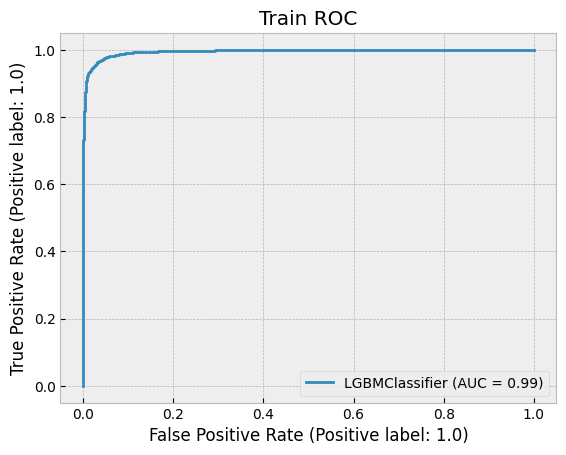

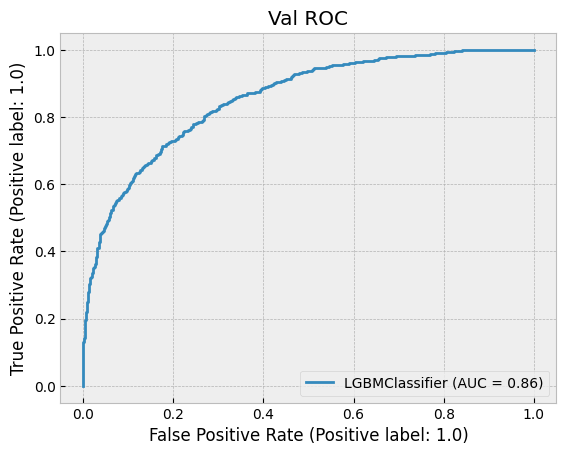

In [19]:
RocCurveDisplay.from_estimator(model, X_train, y_train)
plt.title('Train ROC')
plt.show()
RocCurveDisplay.from_estimator(model, X_val, y_val)
plt.title('Val ROC')
plt.show()